# 一、实验介绍

## 1. 实验内容
在本实验中, 将会使用Mask Wearing自定义标注数据集，通过yolov11模型实现口罩和面部的实例分割

## 2. 实验要点

- 模型训练
- 模型预测

## 3. 实验环境
- Python 3.10
- torch 2.5.1 cu118
- ultralytics 8.3.155

# 二、实验步骤

## 2.1 构建数据集配置文件

导入程序所需依赖，解压数据集文件

In [30]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128

Looking in indexes: https://download.pytorch.org/whl/cu128
  Using cached https://download.pytorch.org/whl/cu128/torch-2.7.1%2Bcu128-cp312-cp312-win_amd64.whl.metadata (27 kB)
  Using cached https://download.pytorch.org/whl/cu128/torchaudio-2.7.1%2Bcu128-cp312-cp312-win_amd64.whl.metadata (6.8 kB)
Using cached https://download.pytorch.org/whl/cu128/torch-2.7.1%2Bcu128-cp312-cp312-win_amd64.whl (3273.0 MB)
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   -- ------------------------------------- 0.5/7.6 MB 5.6 MB/s eta 0:00:02
   ---------- ----------------------------- 2.1/7.6 MB 7.3 MB/s eta 0:00:01
   ------------------------ --------------- 4.7/7.6 MB 8.9 MB/s eta 0:00:01
   ---------------------------------------  7.6/7.6 MB 11.2 MB/s eta 0:00:01
   ---------------------------------------  7.6/7.6 MB 11.2 MB/s eta 0:00:01
   ---------------------------------------  7.6/7.6 MB 11.2 MB/s eta 0:00:01
   ---------------------------------------  7.6/7.6 MB 11.2 MB/

In [1]:
import os
import yaml
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from ultralytics import YOLO
import cv2
import torch
import ultralytics

In [3]:

print(os.environ.get("CUDA_HOME"))
print(os.environ.get("PATH"))
print(os.environ.get("LD_LIBRARY_PATH", ""))

print("torch version:", torch.__version__)
print("torch cuda version:", torch.version.cuda)
print("cuda is available:", torch.cuda.is_available())
print("cuda device count:", torch.cuda.device_count())

None
D:\py_project\Test\.venv\Lib\site-packages\cv2\../../x64/vc14/bin;D:\py_project\Test\.venv\Scripts;D:\anaconda3\condabin;C:\Program Files\Common Files\Oracle\Java\javapath;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8\bin;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8\libnvvp;;;D:\VMware16\bin\;C:\Program Files (x86)\Common Files\Intel\Shared Libraries\redist\intel64\compiler;D:\python\Scripts\;D:\python\;C:\Program Files (x86)\Common Files\Oracle\Java\javapath;C:\Windows\system32;C:\Windows;C:\Windows\System32\Wbem;C:\Windows\System32\WindowsPowerShell\v1.0\;C:\Windows\System32\OpenSSH\;C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common;C:\Program Files\NVIDIA Corporation\NVIDIA NvDLISR;C:\Program Files\dotnet\;D:\git\Git\cmd;C:\Program Files (x86)\Windows Kits\10\Windows Performance Toolkit\;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\WINDOWS\System32\OpenSSH\;D:\anaconda3;D:\anaconda3\Scripts;D:

接下里，我们需要配置YOLO模型训练时需要的配置信息，设置模型需要识别的目标类别（face和mask），选择计算设备（优先使用GPU），并定义了数据集和结果的存储路径。create_dataset_yaml函数用于创建YOLO训练所需的配置文件，指定了训练、验证、测试数据集的路径以及类别信息。

In [5]:
TYPE = ['face', 'mask']

print(f"PyTorch 版本: {torch.__version__}")
print(f"CUDA 可用: {torch.cuda.is_available()}")
import sys
print("当前 Jupyter 使用的 Python 路径:", sys.executable)

device = torch.device('cuda')
print(f"Using device: {device}")

DATASET_DIR = 'dataset'
RESULTS_DIR = 'results'
os.makedirs(RESULTS_DIR, exist_ok=True)

def create_dataset_yaml():
    yaml_content = {
        'path': os.path.abspath(DATASET_DIR),
        'train': 'train/images',
        'val': 'val/images',
        'test': 'test/images',
        'nc': len(TYPE),
        'names': TYPE
    }
    
    yaml_path = os.path.join(DATASET_DIR, 'dataset.yaml')
    with open(yaml_path, 'w') as f:
        yaml.dump(yaml_content, f, default_flow_style=False)
    
    print(f"Created dataset config at {yaml_path}")
    return yaml_path

PyTorch 版本: 2.7.1+cu128
CUDA 可用: True
当前 Jupyter 使用的 Python 路径: D:\py_project\Test\.venv\Scripts\python.exe
Using device: cuda


train_model函数定义了如何训练YOLOv11n模型。首先加载预训练的yolo11n-seg模型权重，设置训练参数：随机种子、数据集配置路径、训练轮数(200轮)、图像尺寸(640x640)、批次大小、并行处理线程数等。训练完成后返回训练结果对象。

In [11]:
# 训练 YOLOv11n model
def train_model(yaml_path):
    # 加载预训练yolo11n-seg
    model = YOLO("yolo11n-seg.pt")
    
    results = model.train(
        seed=100,
        data=yaml_path,
        epochs=100,
        imgsz=640,
        batch=0.6,
        workers=1,
        name='mask_face_detect',
        verbose=True,
        device=device,
        lr0=0.01
    )
    
    print("Training completed.")
    return results

执行配置文件构建和模型训练，输出模型训练评估val指标

In [8]:
# 创建数据集配置文件
yaml_path = create_dataset_yaml()

# 训练模型
print("\nStarting YOLOv11n training...")
results = train_model(yaml_path)
# 总结训练效果
results.summary()

Created dataset config at dataset\dataset.yaml

Starting YOLOv11n training...
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=0.6, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset\dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=mask_face_detect12, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pret

train: Scanning D:\py_project\Test\dataset\train\labels.cache... 80 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:00<?, ?it/s]

AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU) 8.00G total, 0.25G reserved, 0.25G allocated, 7.49G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output


    27618230       142.7         2.395         115.6           nan        (1, 3, 640, 640)                    list
    27618230       285.3         4.979         68.51           nan        (2, 3, 640, 640)                    list
    27618230       570.7         8.326         106.8           nan        (4, 3, 640, 640)                    list
    27618230        1141        15.561         602.4           nan        (8, 3, 640, 640)                    list
    27618230        2283        29.132          4107           nan       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 1 for CUDA:0 2.90G/8.00G (36%) 
train: Fast image access  (ping: 0.10.0 ms, read: 160.1136.7 MB/s, size: 197.3 KB)


train: Scanning D:\py_project\Test\dataset\train\labels.cache... 80 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 108.347.2 MB/s, size: 78.3 KB)


val: Scanning D:\py_project\Test\dataset\val\labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]


Plotting labels to runs\segment\mask_face_detect12\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 176 weight(decay=0.0), 187 weight(decay=0.0005), 186 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 1 dataloader workers
Logging results to runs\segment\mask_face_detect12
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.85G      1.653       4.22       5.03      1.375         14        640: 100%|██████████| 80/80 [00:11<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.71it/s]

                   all         10         69      0.301      0.674      0.372      0.256      0.269      0.617      0.319      0.135



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.95G      1.597      4.105      2.706      1.318         37        640: 100%|██████████| 80/80 [00:10<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.26it/s]

                   all         10         69      0.227      0.493      0.206      0.112     0.0381      0.322     0.0194    0.00912



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.95G      2.168       4.82      3.051      1.675         19        640: 100%|██████████| 80/80 [00:09<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.56it/s]

                   all         10         69     0.0179       0.13      0.008    0.00219    0.00596      0.116    0.00377   0.000953



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.05G      2.871      5.099      3.573      2.183         19        640: 100%|██████████| 80/80 [00:10<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         10         69     0.0308      0.129     0.0174    0.00963          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.15G       2.24      4.975      3.774      1.789         22        640: 100%|██████████| 80/80 [00:09<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.54it/s]

                   all         10         69          0          0          0          0   0.000361     0.0294   0.000192   2.86e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.15G      2.229      5.121      3.196      1.713          7        640: 100%|██████████| 80/80 [00:09<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 18.56it/s]

                   all         10         69    0.00238     0.0714    0.00165    0.00049    0.00116      0.029   0.000603   9.22e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.15G      2.061      4.348      2.623      1.636         25        640: 100%|██████████| 80/80 [00:09<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 17.01it/s]

                   all         10         69   0.000422     0.0294    0.00024   9.31e-05   0.000211     0.0147   0.000114   6.78e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.16G       2.03      3.981      2.897      1.615          2        640: 100%|██████████| 80/80 [00:09<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 17.42it/s]

                   all         10         69          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.32G      2.155      3.905      2.982      1.753         61        640: 100%|██████████| 80/80 [00:09<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.82it/s]

                   all         10         69          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.32G      1.962      3.844      2.389      1.621          5        640: 100%|██████████| 80/80 [00:09<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 17.32it/s]

                   all         10         69          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.32G      1.975      3.948      2.419      1.575          4        640: 100%|██████████| 80/80 [00:10<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 17.37it/s]

                   all         10         69      0.492      0.275      0.237       0.13      0.508      0.275      0.221       0.11



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.32G      1.795      3.432      1.947      1.474         28        640: 100%|██████████| 80/80 [00:09<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.15it/s]

                   all         10         69      0.305      0.622      0.307      0.177       0.31      0.622      0.297      0.146



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.32G      1.705      3.204      1.994      1.448         16        640: 100%|██████████| 80/80 [00:09<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.29it/s]

                   all         10         69     0.0354      0.348     0.0203     0.0127      0.035      0.334     0.0197     0.0115



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100       2.6G      1.601      3.107      1.868      1.425         79        640: 100%|██████████| 80/80 [00:09<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.14it/s]


                   all         10         69      0.768      0.459      0.598       0.37      0.712      0.407      0.519      0.213

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100       2.6G       1.57      2.911      1.737      1.422         21        640: 100%|██████████| 80/80 [00:10<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.80it/s]

                   all         10         69       0.78      0.578      0.683      0.458       0.67      0.604      0.647      0.359



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100       2.6G      1.548      2.997      1.556      1.422         13        640: 100%|██████████| 80/80 [00:10<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 17.81it/s]

                   all         10         69      0.643      0.533      0.588      0.382      0.615      0.508      0.544      0.291



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100       2.6G      1.578      2.984      1.648      1.426         22        640: 100%|██████████| 80/80 [00:09<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.62it/s]

                   all         10         69      0.727      0.622      0.633      0.387       0.66      0.523      0.549      0.291



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100       2.6G       1.51      2.809      1.495      1.306        329        640: 100%|██████████| 80/80 [00:09<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.64it/s]


                   all         10         69      0.824      0.623      0.699      0.437      0.657      0.603       0.59       0.29

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100       2.6G      1.556      2.901       1.49      1.362         58        640: 100%|██████████| 80/80 [00:10<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.49it/s]

                   all         10         69      0.814      0.639      0.724      0.461      0.695      0.595      0.612      0.322



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100       2.6G      1.483      2.783      1.311      1.333         32        640: 100%|██████████| 80/80 [00:10<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.01it/s]

                   all         10         69      0.756      0.621      0.672      0.421      0.693       0.55      0.578      0.294



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100       2.6G      1.451      2.627      1.289      1.272         10        640: 100%|██████████| 80/80 [00:10<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.34it/s]

                   all         10         69      0.758      0.521      0.629      0.391      0.708      0.438      0.537      0.255



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100       2.6G       1.55      2.935      1.492      1.396         34        640: 100%|██████████| 80/80 [00:10<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.52it/s]

                   all         10         69      0.711      0.715       0.72       0.47      0.804      0.595      0.691      0.366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100       2.6G      1.463       2.58      1.222      1.268          2        640: 100%|██████████| 80/80 [00:10<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.08it/s]

                   all         10         69      0.841      0.687      0.802      0.545      0.842      0.682       0.79      0.424



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100       2.6G      1.384      2.562      1.209      1.238         27        640: 100%|██████████| 80/80 [00:10<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.22it/s]

                   all         10         69      0.864      0.616      0.781      0.537      0.885      0.631      0.769      0.389



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100       2.6G      1.359       2.52      1.169      1.268          4        640: 100%|██████████| 80/80 [00:10<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.35it/s]

                   all         10         69      0.809      0.614      0.732      0.469      0.722       0.61      0.669      0.345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100       2.6G      1.363      2.431      1.249      1.215         34        640: 100%|██████████| 80/80 [00:10<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.40it/s]

                   all         10         69      0.768      0.558      0.631      0.417      0.737      0.528      0.586      0.311



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100       2.6G      1.402      2.486      1.238      1.265         12        640: 100%|██████████| 80/80 [00:09<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 17.46it/s]

                   all         10         69      0.888      0.735      0.837      0.556      0.834      0.693      0.795      0.432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100       2.6G      1.384      2.559      1.198      1.253          4        640: 100%|██████████| 80/80 [00:09<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 17.05it/s]

                   all         10         69      0.862      0.754      0.841      0.586      0.796      0.705       0.78      0.455



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100       2.6G      1.404      2.517      1.141      1.271         16        640: 100%|██████████| 80/80 [00:10<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.95it/s]


                   all         10         69      0.808       0.81      0.854       0.59      0.778      0.782      0.821      0.473

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100       2.6G      1.331       2.41      1.157      1.283          8        640: 100%|██████████| 80/80 [00:10<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.69it/s]

                   all         10         69        0.8      0.819      0.843      0.579      0.786      0.805      0.814      0.467



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100       2.6G      1.277      2.307      1.026      1.181         16        640: 100%|██████████| 80/80 [00:11<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.59it/s]

                   all         10         69      0.833      0.841       0.87      0.598      0.797      0.784      0.823      0.451



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100       2.6G       1.28      2.382      1.018      1.225          7        640: 100%|██████████| 80/80 [00:10<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 17.28it/s]

                   all         10         69      0.877      0.798       0.89      0.623      0.939      0.649      0.809      0.465



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100       2.6G      1.271      2.276      1.006      1.206         13        640: 100%|██████████| 80/80 [00:10<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.79it/s]

                   all         10         69      0.918      0.835      0.917      0.639      0.849      0.779      0.842      0.489



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100       2.6G      1.296       2.35      1.086      1.265         11        640: 100%|██████████| 80/80 [00:10<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.37it/s]

                   all         10         69      0.813      0.871      0.918      0.622      0.744      0.842      0.849      0.485



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100       2.6G      1.217      2.238      0.939      1.138         50        640: 100%|██████████| 80/80 [00:10<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.66it/s]

                   all         10         69      0.865       0.71      0.835      0.589      0.832      0.678      0.794      0.444



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100       2.6G       1.26      2.436     0.9412      1.207         26        640: 100%|██████████| 80/80 [00:10<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.59it/s]

                   all         10         69      0.879      0.757       0.84      0.586      0.811      0.701      0.767      0.451



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100       2.6G      1.167      2.323      0.933      1.154         28        640: 100%|██████████| 80/80 [00:10<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.97it/s]

                   all         10         69      0.845      0.863      0.856      0.601      0.776      0.793      0.776      0.453



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100       2.6G      1.213      2.205     0.9821      1.152          6        640: 100%|██████████| 80/80 [00:09<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.70it/s]

                   all         10         69      0.907      0.781      0.846      0.599      0.861      0.725      0.781      0.459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100       2.6G      1.197      2.337      1.006      1.167         12        640: 100%|██████████| 80/80 [00:10<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 17.39it/s]

                   all         10         69      0.869      0.782        0.9      0.643      0.792      0.711       0.81      0.483



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100       2.6G      1.193      2.299      1.051      1.201         23        640: 100%|██████████| 80/80 [00:11<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 17.18it/s]

                   all         10         69      0.841      0.811      0.842      0.599      0.727      0.713      0.737       0.44



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100       2.6G        1.2      2.223     0.9613      1.149          8        640: 100%|██████████| 80/80 [00:11<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.07it/s]

                   all         10         69      0.903      0.817      0.843      0.573       0.79      0.719      0.733      0.446



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100       2.6G      1.123      2.098     0.8898      1.156         13        640: 100%|██████████| 80/80 [00:10<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.23it/s]

                   all         10         69      0.913       0.87      0.929      0.617      0.844      0.798      0.851      0.474



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100       2.6G      1.281      2.231      1.047      1.198         65        640: 100%|██████████| 80/80 [00:10<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.10it/s]

                   all         10         69      0.908       0.74      0.853      0.591      0.854      0.696      0.798      0.445



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100       2.6G      1.226      2.217     0.9491      1.143         12        640: 100%|██████████| 80/80 [00:10<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.83it/s]

                   all         10         69      0.892      0.764      0.874      0.583      0.806      0.693      0.785       0.45



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100       2.6G      1.194       2.13     0.9026       1.13         15        640: 100%|██████████| 80/80 [00:10<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.14it/s]

                   all         10         69      0.935      0.782      0.867      0.593      0.877      0.724      0.802      0.441



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100       2.6G      1.211      2.145      1.082      1.126         52        640: 100%|██████████| 80/80 [00:10<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 17.30it/s]

                   all         10         69      0.925      0.766      0.891      0.612      0.863      0.709       0.81      0.454



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100       2.6G      1.202      2.119     0.8983      1.143         40        640: 100%|██████████| 80/80 [00:10<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 17.45it/s]

                   all         10         69       0.84      0.824      0.875      0.639      0.871      0.713        0.8      0.463



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100       2.6G      1.213      2.238      1.022      1.195         26        640: 100%|██████████| 80/80 [00:10<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 17.36it/s]


                   all         10         69      0.906      0.795      0.893      0.641      0.853      0.753      0.821      0.483

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100       2.6G      1.124      2.014     0.8549      1.119         23        640: 100%|██████████| 80/80 [00:10<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.59it/s]

                   all         10         69      0.913      0.822      0.928      0.666      0.897      0.808      0.881      0.527



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100       2.6G      1.202      2.074     0.8799      1.184          8        640: 100%|██████████| 80/80 [00:10<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.76it/s]

                   all         10         69      0.919      0.826      0.927      0.654      0.868      0.783      0.864      0.498



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100       2.6G      1.106      1.961     0.8133      1.142          8        640: 100%|██████████| 80/80 [00:10<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 17.50it/s]

                   all         10         69      0.854      0.865      0.901      0.633      0.823      0.841      0.857      0.506



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100       2.6G      1.154      2.023     0.8999      1.112          4        640: 100%|██████████| 80/80 [00:10<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.77it/s]

                   all         10         69       0.93      0.823      0.913      0.628      0.877      0.781      0.849      0.504



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100       2.6G      1.159      2.076      0.862      1.145         27        640: 100%|██████████| 80/80 [00:11<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.07it/s]

                   all         10         69      0.877      0.884      0.913      0.627      0.848      0.855      0.864      0.499



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100       2.6G      1.193      2.077     0.8876      1.143         14        640: 100%|██████████| 80/80 [00:10<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 17.25it/s]


                   all         10         69       0.86      0.884      0.914      0.633      0.812      0.841      0.829      0.495

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100       2.6G      1.135      2.029     0.7867      1.127          4        640: 100%|██████████| 80/80 [00:10<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 17.29it/s]

                   all         10         69      0.933      0.884      0.924      0.654      0.886      0.841      0.857      0.509



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100       2.6G      1.123      1.962     0.7626      1.129         16        640: 100%|██████████| 80/80 [00:10<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.09it/s]

                   all         10         69      0.949      0.826      0.916       0.65      0.833      0.855      0.848       0.52



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100       2.6G      1.139      2.051     0.8126      1.148         33        640: 100%|██████████| 80/80 [00:11<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.46it/s]


                   all         10         69      0.967      0.826      0.925      0.628      0.898      0.769      0.833      0.512

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100       2.6G      1.122          2     0.7971      1.137          6        640: 100%|██████████| 80/80 [00:12<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.81it/s]

                   all         10         69       0.97      0.796       0.92      0.627      0.854      0.812      0.856      0.505



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100       2.6G      1.166      2.011     0.7955      1.125         17        640: 100%|██████████| 80/80 [00:11<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.18it/s]

                   all         10         69      0.941      0.868      0.931      0.626      0.925      0.854      0.906      0.512



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100       2.6G      1.119      1.919     0.7843      1.122         13        640: 100%|██████████| 80/80 [00:10<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.03it/s]

                   all         10         69      0.933      0.855      0.914       0.64      0.931      0.855      0.912      0.522



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100       2.6G       1.15      2.005     0.8226       1.14         28        640: 100%|██████████| 80/80 [00:10<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.76it/s]

                   all         10         69       0.97      0.855      0.941      0.666      0.893       0.85       0.91      0.515



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100       2.6G      1.144       2.02     0.7617      1.122         11        640: 100%|██████████| 80/80 [00:10<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.21it/s]

                   all         10         69      0.947      0.902       0.95       0.69      0.932      0.888      0.932      0.531



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100       2.6G      1.084      1.928     0.7903      1.085         15        640: 100%|██████████| 80/80 [00:10<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.45it/s]

                   all         10         69      0.902      0.939      0.946      0.673      0.888      0.925      0.928       0.54



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100       2.6G      1.132      2.063     0.7931       1.14         21        640: 100%|██████████| 80/80 [00:11<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.59it/s]

                   all         10         69       0.97      0.918       0.96      0.674       0.94       0.89      0.939      0.539



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100       2.6G      1.089      1.939     0.7765      1.092         36        640: 100%|██████████| 80/80 [00:11<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.27it/s]

                   all         10         69       0.99      0.884       0.96      0.676      0.918      0.885      0.932      0.541



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100       2.6G      1.058      1.924     0.7512      1.142         20        640: 100%|██████████| 80/80 [00:10<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 17.04it/s]

                   all         10         69      0.967      0.897      0.956      0.688      0.934      0.914      0.942      0.553



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100       2.6G      1.084      1.943      0.704      1.096          6        640: 100%|██████████| 80/80 [00:10<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.92it/s]


                   all         10         69      0.952      0.937      0.959      0.659      0.923      0.909      0.931      0.535

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100       2.6G      1.078      1.858     0.6722      1.053         31        640: 100%|██████████| 80/80 [00:10<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.39it/s]

                   all         10         69      0.964      0.902      0.937      0.651      0.932      0.874      0.888      0.524



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100       2.6G      1.099       2.03     0.7893      1.093          8        640: 100%|██████████| 80/80 [00:10<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 17.27it/s]

                   all         10         69      0.941      0.826      0.912      0.644      0.922      0.813       0.86      0.515



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100       2.6G      1.098      2.055     0.7734      1.081         33        640: 100%|██████████| 80/80 [00:10<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.57it/s]

                   all         10         69       0.89       0.87      0.908      0.641      0.842      0.827       0.84      0.504



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100       2.6G      1.076      1.878     0.6952      1.085          6        640: 100%|██████████| 80/80 [00:10<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 17.38it/s]

                   all         10         69      0.896      0.911      0.922      0.635      0.865       0.87      0.886      0.526



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100       2.6G      1.047      2.001     0.7145       1.11          6        640: 100%|██████████| 80/80 [00:10<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.82it/s]

                   all         10         69      0.882      0.899       0.92      0.652      0.871      0.839      0.886      0.529



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100       2.6G     0.9875      1.814     0.6899      1.085         34        640: 100%|██████████| 80/80 [00:10<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 17.10it/s]

                   all         10         69      0.907      0.889      0.932      0.662      0.877      0.861      0.883      0.534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100       2.6G     0.9781      1.785     0.6547      1.045         13        640: 100%|██████████| 80/80 [00:10<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.75it/s]

                   all         10         69       0.91      0.922      0.934      0.654      0.824      0.836      0.851      0.534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100       2.6G      1.049      1.781     0.6633      1.074         12        640: 100%|██████████| 80/80 [00:10<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.73it/s]

                   all         10         69      0.915      0.894      0.927      0.661      0.867      0.864      0.881      0.535



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100       2.6G      1.012      1.728     0.6899      1.057         18        640: 100%|██████████| 80/80 [00:11<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 17.28it/s]


                   all         10         69      0.933      0.884      0.941      0.661      0.912      0.825      0.887      0.539

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100       2.6G      1.056      1.931     0.7095       1.07          4        640: 100%|██████████| 80/80 [00:10<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 17.20it/s]


                   all         10         69      0.938      0.908      0.945      0.668      0.919      0.875      0.918      0.549

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100       2.6G       1.03      1.845     0.6457       1.05          8        640: 100%|██████████| 80/80 [00:10<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.66it/s]

                   all         10         69      0.917      0.907      0.946       0.67      0.903      0.882       0.92      0.546



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100       2.6G      0.982      1.809     0.6238      1.023         27        640: 100%|██████████| 80/80 [00:11<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 17.07it/s]


                   all         10         69      0.921      0.894       0.94      0.652      0.906       0.88      0.923      0.557

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100       2.6G      1.064      1.804     0.6699      1.053          4        640: 100%|██████████| 80/80 [00:11<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.74it/s]

                   all         10         69      0.912      0.891       0.93      0.648      0.885      0.864      0.904      0.552



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100       2.6G     0.9962      1.791     0.6531      1.069          4        640: 100%|██████████| 80/80 [00:10<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.93it/s]

                   all         10         69      0.921      0.872      0.941      0.661      0.905      0.858      0.911      0.552



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100       2.6G      1.042      1.828      0.668      1.069          7        640: 100%|██████████| 80/80 [00:10<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.78it/s]

                   all         10         69      0.951      0.898      0.951      0.685      0.924      0.892      0.922      0.565



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100       2.6G      1.005      1.767     0.6172      1.032          9        640: 100%|██████████| 80/80 [00:11<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 17.60it/s]

                   all         10         69      0.925      0.912      0.943      0.681      0.909        0.9      0.926      0.563



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100       2.6G      1.074      1.876     0.6689      1.058         10        640: 100%|██████████| 80/80 [00:10<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.72it/s]


                   all         10         69      0.976      0.878      0.952        0.7       0.96      0.864      0.925       0.56

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100       2.6G      1.023      1.728     0.6415      1.055         17        640: 100%|██████████| 80/80 [00:11<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.17it/s]

                   all         10         69      0.936      0.913      0.947      0.692      0.922      0.899      0.914      0.554



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100       2.6G     0.9911      1.756      0.664      1.039         11        640: 100%|██████████| 80/80 [00:11<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.09it/s]

                   all         10         69      0.934      0.913      0.946      0.684       0.92      0.899      0.913      0.554



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100       2.6G       1.01      1.757     0.6433      1.085          6        640: 100%|██████████| 80/80 [00:11<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.56it/s]

                   all         10         69      0.966      0.906      0.959      0.682      0.951      0.892      0.925      0.558



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100       2.6G      1.003      1.773     0.6519      1.045          7        640: 100%|██████████| 80/80 [00:15<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.71it/s]

                   all         10         69      0.974      0.905      0.952      0.681      0.943      0.876      0.898      0.553



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100       2.6G     0.9786      1.779     0.6152      1.052         12        640: 100%|██████████| 80/80 [00:17<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.41it/s]

                   all         10         69      0.974      0.907       0.96      0.686      0.944      0.878      0.905      0.558



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100       2.6G      1.023      1.972     0.6448      1.044         57        640: 100%|██████████| 80/80 [00:15<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]

                   all         10         69      0.922      0.927      0.955      0.671      0.942      0.877      0.902      0.551


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100       2.6G     0.9779      1.655     0.6391      1.053         16        640: 100%|██████████| 80/80 [00:14<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.25it/s]

                   all         10         69      0.915       0.92      0.964      0.688      0.922      0.855       0.91      0.553



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100       2.6G      0.913      1.591     0.6025      1.053          4        640: 100%|██████████| 80/80 [00:14<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         10         69      0.929      0.942      0.962      0.691      0.906      0.884      0.905      0.549



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100       2.6G     0.9146      1.603     0.5814      1.034         22        640: 100%|██████████| 80/80 [00:14<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.83it/s]

                   all         10         69      0.966      0.907      0.964      0.684      0.936      0.879       0.91      0.551



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100       2.6G     0.9151      1.595     0.5782      1.013         33        640: 100%|██████████| 80/80 [00:14<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         10         69      0.952      0.869      0.946      0.672      0.921      0.841      0.876      0.529



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100       2.6G     0.8878      1.567     0.5416       1.02          6        640: 100%|██████████| 80/80 [00:14<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

                   all         10         69      0.967      0.916      0.947      0.667      0.922      0.874      0.906      0.545



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100       2.6G     0.9261      1.553     0.5747      1.042         23        640: 100%|██████████| 80/80 [00:14<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         10         69      0.961      0.902      0.944      0.671       0.93      0.874      0.908      0.547



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100       2.6G      0.913      1.575     0.5525      1.007          6        640: 100%|██████████| 80/80 [00:14<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         10         69      0.976      0.916      0.946       0.67      0.945      0.888      0.909      0.547



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100       2.6G     0.9104      1.559     0.5572       1.03          2        640: 100%|██████████| 80/80 [00:13<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.73it/s]

                   all         10         69      0.958      0.901      0.939       0.67      0.927      0.872      0.903      0.538



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100       2.6G     0.8934      1.573     0.5471      1.008        167        640: 100%|██████████| 80/80 [00:14<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         10         69      0.967      0.918      0.948      0.686      0.937      0.889      0.899      0.554



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100       2.6G     0.8778      1.504      0.533     0.9939         37        640: 100%|██████████| 80/80 [00:13<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         10         69      0.954      0.916      0.946      0.682      0.925      0.888      0.897      0.547



100 epochs completed in 0.356 hours.
Optimizer stripped from runs\segment\mask_face_detect12\weights\last.pt, 55.8MB
Optimizer stripped from runs\segment\mask_face_detect12\weights\best.pt, 55.8MB

Validating runs\segment\mask_face_detect12\weights\best.pt...
Ultralytics 8.3.158  Python-3.12.0 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11l-seg summary (fused): 203 layers, 27,586,134 parameters, 0 gradients, 141.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/5 [00:00<?, ?it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.37it/s]


                   all         10         69      0.976      0.879      0.952        0.7       0.96      0.865      0.925      0.561
                  face         10         35      0.984      0.886       0.94      0.682      0.953      0.857      0.885      0.437
                  mask         10         34      0.967      0.872      0.965      0.718      0.967      0.872      0.965      0.684
Speed: 0.7ms preprocess, 46.1ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs\segment\mask_face_detect12
Training completed.


[{'class_name': 'face',
  'box-p': 0.98444,
  'box-r': 0.88571,
  'box-f1': 0.93247,
  'box-map': 0.70009,
  'box-map50': 0.95215,
  'box-map75': 0.83692,
  'mask-p': 0.95269,
  'mask-r': 0.85714,
  'mask-f1': 0.90239,
  'mask-map': 0.56051,
  'mask-map50': 0.92491,
  'mask-map75': 0.59279},
 {'class_name': 'mask',
  'box-p': 0.96738,
  'box-r': 0.87236,
  'box-f1': 0.91741,
  'box-map': 0.70009,
  'box-map50': 0.95215,
  'box-map75': 0.83692,
  'mask-p': 0.96738,
  'mask-r': 0.87236,
  'mask-f1': 0.91741,
  'mask-map': 0.56051,
  'mask-map50': 0.92491,
  'mask-map75': 0.59279}]

下面函数用于评估训练好的模型在测试集上的性能。加载保存的最佳模型权重，在测试集上进行验证，并输出多种评估指标：mAP50-95（不同IoU阈值下的平均精度均值）、mAP50（IoU=0.5时的平均精度）、精确率和召回率，这些指标用于衡量模型的检测和分割质量

In [9]:
# 在test集使用训练好的模型得到评估指标
def validate_model(model_path):
    model = YOLO(model_path)
    metrics = model.val(data=os.path.join(DATASET_DIR, 'dataset.yaml'), split='test')
    
    print("\nValidation Results on Test Set:")
    print(f"mAP50-95: {metrics.box.map}")
    print(f"mAP50: {metrics.box.map50}")
    print(f"Precision: {metrics.box.p}")
    print(f"Recall: {metrics.box.r}")
    
    return metrics

执行测试代码

In [10]:
# 在测试集上验证结果
print("\nValidating model on test set...")
model_path = "runs/segment/mask_face_detect12/weights/best.pt"
metrics = validate_model(model_path)
print("\nTraining and evaluation complete!")


Validating model on test set...
Ultralytics 8.3.158  Python-3.12.0 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11l-seg summary (fused): 203 layers, 27,586,134 parameters, 0 gradients, 141.9 GFLOPs
val: Fast image access  (ping: 0.50.6 ms, read: 157.2136.4 MB/s, size: 219.8 KB)


val: Scanning D:\py_project\Test\dataset\test\labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.60s/it]


                   all         18        163      0.905      0.788      0.886      0.599      0.851      0.753      0.829      0.442
                  face         18         89       0.89      0.809       0.89      0.596      0.838      0.775      0.826       0.37
                  mask         17         74      0.919      0.767      0.882      0.603      0.864       0.73      0.831      0.515
Speed: 5.0ms preprocess, 69.6ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\segment\val9

Validation Results on Test Set:
mAP50-95: 0.5991200987139496
mAP50: 0.8861779036874474
Precision: [    0.89018     0.91904]
Recall: [    0.80899     0.76702]

Training and evaluation complete!


输入一个图片，输出实例分割的结果展示

Processing photo1.jpg...

0: 640x480 1 face, 1 mask, 31.3ms
Speed: 5.6ms preprocess, 31.3ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 480)


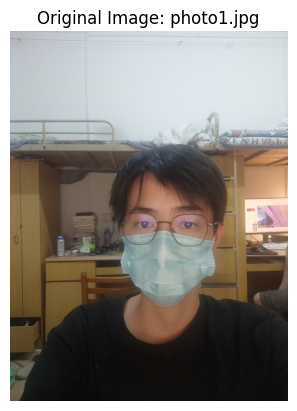

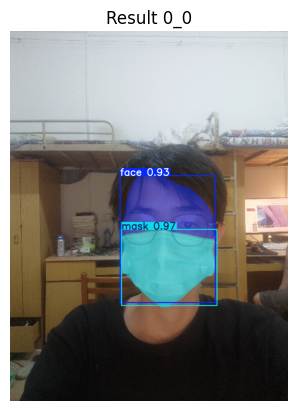

Saved result to D:\py_project\Test\results\results_0_0.jpg
Processing photo2.jpg...

0: 640x480 2 faces, 1 mask, 26.6ms
Speed: 4.0ms preprocess, 26.6ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 480)


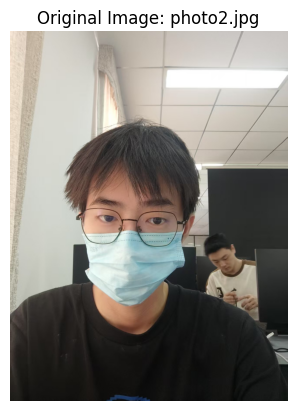

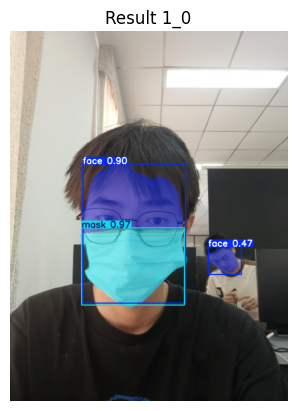

Saved result to D:\py_project\Test\results\results_1_0.jpg
Processing photo3.jpg...

0: 640x480 1 face, 2 masks, 27.0ms
Speed: 5.7ms preprocess, 27.0ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 480)


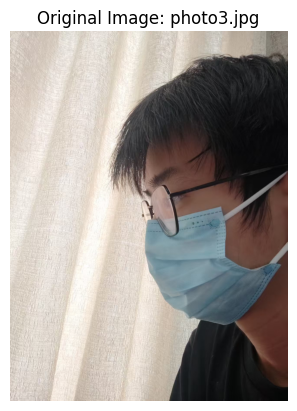

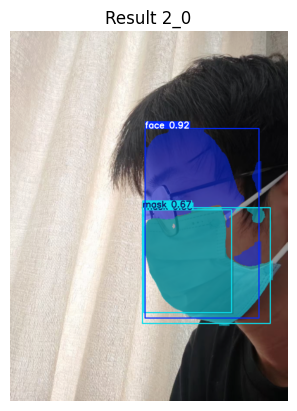

Saved result to D:\py_project\Test\results\results_2_0.jpg
Processing photo4.jpg...

0: 640x480 1 face, 26.1ms
Speed: 4.6ms preprocess, 26.1ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 480)


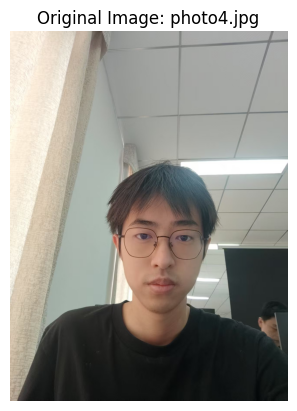

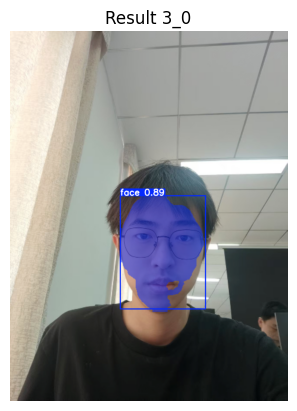

Saved result to D:\py_project\Test\results\results_3_0.jpg


In [20]:
import os
from PIL import Image
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load a pretrained YOLO model
model = YOLO(model_path)

# List of input images
input_images = ["photo1.jpg", "photo2.jpg", "photo3.jpg","photo4.jpg"]

# Ensure the output directory exists
output_dir = r"D:\py_project\Test\results"
os.makedirs(output_dir, exist_ok=True)

# Process each image
for img_index, input_img in enumerate(input_images):
    print(f"Processing {input_img}...")
    results = model([input_img])  # Get results for the current image

    # Display the original image
    plt.imshow(Image.open(input_img))
    plt.title(f"Original Image: {input_img}")
    plt.axis('off')
    plt.show()

    # Visualize and save the results
    for i, r in enumerate(results):
        im_bgr = r.plot()  # BGR-order numpy array
        im_rgb = Image.fromarray(im_bgr[..., ::-1])  # Convert to RGB-order PIL image
        plt.imshow(im_rgb)
        plt.title(f"Result {img_index}_{i}")
        plt.axis('off')
        plt.show()

        # Save results to disk
        result_path = os.path.join(output_dir, f"results_{img_index}_{i}.jpg")
        r.save(result_path)
        print(f"Saved result to {result_path}")

# 三、实验任务

1. 理解实验手册中的代码，并撰写相关实验报告。

2. 尝试使用其他模型构建口罩和面部实例分割

In [ ]:
# 请在此处填写答案

# 四、参考资料

1. https://docs.ultralytics.com/zh/tasks/segment/